In [1]:
import os
import json
import scipy
import jsonlines
import numpy as np
import pandas as pd
from scipy.stats import spearmanr, pearsonr, weightedtau
from collections import defaultdict
from matplotlib import pyplot as plt

In [2]:
TUNED_RESULTS = {
    "mnli": [84.7, 82.2, 83.9, 81.5, 87.6, 84.0],
    "qqp": [89.6, 88.5, 89.2, 87.8, 91.9, 89.4],
    "qnli": [91.8, 89.2, 91.0, 88.2, 92.8, 90.8],
    "sst2": [92.7, 91.3, 91.7, 90.4, 94.8, 92.5],
    "cola": [56.3, 51.3, 58.2, 47.2, 63.6, 59.3],
    "mrpc": [88.6, 87.5, 87.8, 85.6, 90.2, 86.6],
    "rte": [69.3, 59.9, 66.1, 60.6, 78.7, 67.9],
    "wnli": [53.5, 56.3, 46.5, 56.3, 57.7, 52.1],
}

DATA_SIZES = {
    "mnli": 392702,
    "qqp": 363846,
    "qnli": 104743,
    "sst2": 67349,
    "cola": 8551,
    "mrpc": 3668,
    "rte": 2490,
    "wnli": 635,
}

DATASETS = ['cola', 'sst2', 'mrpc', 'qqp', 'mnli', 'qnli', 'rte', 'wnli']
PLMS = ["bert-base-uncased",
        "distilbert-base-uncased",
        "bert-base-cased",
        "distilbert-base-cased",
        "roberta-base",
        "distilroberta-base"]

POOLING = 'first'

In [3]:
def get_rank(pred_list, gt_list):
    pred_rank = np.argsort(-np.array(pred_list))
    rank = np.where(pred_rank==np.argmax(gt_list))[0].item() + 1
    return rank

def avg_time(time_list, unit):
    sum_time = 0.
    for t in time_list:
        if t == '-':
            return t
        sum_time += float(t)
    try:
        return f"%.1f%s"% (sum_time / len(time_list), unit)
    except:
        return "-"

In [4]:
MODEL_SIM_METHODS = ["DSE-corr", "DSE-dot", "DSE-cos", "DSE-l2", "PA",\
                    "RSA-corr", "RSA-cos", "RSA-l2", "RSA-dot", "DDS-corr", "DDS-cos", "DDS-dot", "DDS-l2"]

STATIC_METHODS = ["kNN-1-l2", "kNN-3-l2", "kNN-5-l2", "kNN-1-cos", "kNN-3-cos", "kNN-5-cos", "kNN-1-corr", "kNN-3-corr", "kNN-5-corr",\
                  "GBC", "HScore", "HScoreR", "MSC-l2", "MSC-cos", "MSC-corr", "LFC-corr", "LFC-cos", "LFC-dot", "LFC-l2", "TransRate", "NLEEP",\
                  "PARC-corr", "PARC-cos", "PARC-dot", "PARC-l2", ]

DYNAMIC_METHODS = ["Logistic", "LogME", "SFDA", "PACTran-1-100", "PACTran-1-10", "PACTran-10-1000", "PACTran-10-100",\
               "PACTran-0.1-10", "PACTran-0.1-1",]

METHOD_SHOW_NAME = {
    "DSE-l2": "DSE", 
    "PA": "PS",
    "RSA-cos": "RSA",
    "RSA-corr": "RSA",
    "kNN-5-corr": r"$k$NN",
    "GBC": "GBC",
    "HScore": "H-Score", 
    "HScoreR": "Reg. H-Score",
    "MSC-cos": "MSC",
    "LFC-cos": "LFC",
    "TransRate": "TransRate",
    "NLEEP": "NLEEP",
    "PARC-corr": "PARC",
    "Logistic": "Logistic",
    "LogME": "LogME",
    "SFDA": "SFDA",
    "PACTran-1-10": "PACTran",
}

In [68]:
def summarize_results(data_ratios, embedding_sizes, target_model_lm, plot_methods=[], best_dim_dict=None):

    all_results = {}
    main_results = {}
    for data_ratio in data_ratios:
        all_results[data_ratio] = {}
        main_results[data_ratio] = {}
        for embed_size in embedding_sizes:
            all_results[data_ratio][embed_size] = {}
            main_results[data_ratio][embed_size] = {}
            for method in ALL_METHODS:
                all_results[data_ratio][embed_size][method] = defaultdict(list)
                for dataset in DATASETS:
                    method_result_file = f"../../resources/output/glue/{dataset}/model_selection_results/{method+'-'+target_model_lm if method in MODEL_SIM_METHODS else method}_{int(data_ratio*100)}%_{embed_size}_{POOLING}.jsonl"
                    if not os.path.exists(method_result_file):
                        if method in plot_methods and best_dim_dict is not None and embed_size==best_dim_dict[method]:
                            print(method_result_file)
                            pass
                        else:
                            break
                    
                    reader =  list(jsonlines.open(method_result_file))
                    rank = 0.
                    spr = 0.
                    pear = 0.
                    wtau = 0.
                    scoring_time = 0.
                    num_seeds = len(reader[0]['all_scores'])
                    assert len(reader) == len(PLMS)
                    for seed_idx in range(num_seeds):
                        model_result_list = []
                        model_time_list = []
                        for enc_idx, result_dict in enumerate(reader):
                            assert PLMS[enc_idx] == result_dict['model'] 
                            model_result_list.append(result_dict['all_scores'][seed_idx])
                            model_time_list.append(result_dict['all_times'][seed_idx])
                        
                        revert_methods = ['PACTran']
                        if any([method.startswith(m) for m in revert_methods]):
                            model_result_list = [s*-1 for s in model_result_list]
                        
                        rank += get_rank(model_result_list, TUNED_RESULTS[dataset])
                        # if np.std(model_result_list) == 0:
                        #     print(method_result_file)
                        spr += spearmanr(model_result_list, TUNED_RESULTS[dataset]).statistic
                        pear += pearsonr(model_result_list, TUNED_RESULTS[dataset]).statistic
                        wtau += weightedtau(model_result_list, TUNED_RESULTS[dataset]).statistic
                        scoring_time += np.sum(model_time_list)
                    
                    rank /= num_seeds
                    spr /= num_seeds
                    pear /= num_seeds
                    wtau /= num_seeds
                    scoring_time /= num_seeds
                    
                    training_time = '-'
                    # if any([method.split('-')[0]==m for m in model_sim_methods]):
                    if method in MODEL_SIM_METHODS:
                        target_training_file = f"../../resources/output/glue/{dataset}/encoded_dataset/target-model_{target_model_lm}_{POOLING}/target-model-5_first.jsonl"
                        with jsonlines.open(target_training_file) as reader:
                            for result_dict in reader:
                                training_time = str(round(result_dict['avg_time'] / (60 * 60), 2))
                                break

                    all_results[data_ratio][embed_size][method]['acc@1'].append(float(rank==1))
                    all_results[data_ratio][embed_size][method]['mrr'].append(1./rank)
                    all_results[data_ratio][embed_size][method]['spr'].append(spr)
                    all_results[data_ratio][embed_size][method]['pear'].append(pear)
                    all_results[data_ratio][embed_size][method]['wtau'].append(wtau)
                    all_results[data_ratio][embed_size][method]['scoring_time'].append(scoring_time)
                    all_results[data_ratio][embed_size][method]['training_time'].append(training_time)

            def avg_score(x, metric):
                if method in plot_methods and embed_size==best_dim_dict[method]:
                    assert len(all_results[data_ratio][embed_size][x][metric]) == len(DATASETS)
                try:
                    assert len(all_results[data_ratio][embed_size][x][metric]) == len(DATASETS)
                except: 
                    # print(x, len(all_results[data_ratio][embed_size][x][metric]))
                    return "-1"
                return '%.2f'%np.mean(all_results[data_ratio][embed_size][x][metric])


            main_results[data_ratio][embed_size]['overall'] = pd.DataFrame({
                "Methods": ALL_METHODS,
                "MRR": map(lambda x: avg_score(x, 'mrr'), ALL_METHODS),
                "Mean SCC": map(lambda x: avg_score(x, 'spr'), ALL_METHODS),
                "Training Time": map(lambda x: avg_time(all_results[data_ratio][embed_size][x]['training_time'], 'h'), ALL_METHODS),
                "Scoring Time": map(lambda x: avg_time(all_results[data_ratio][embed_size][x]['scoring_time'], 's'), ALL_METHODS)
            })
            
            main_results[data_ratio][embed_size]['mrr_dataset'] = pd.DataFrame( \
                np.array([[m] + ['%.2f'%s for s in all_results[data_ratio][embed_size][m]['mrr']] \
                          if len(['%.2f'%s for s in all_results[data_ratio][embed_size][m]['mrr']])!=0 \
                          else [m] + ['-']*8 \
                          for m in all_results[data_ratio][embed_size].keys()]), columns=['Methods'] + DATASETS)
            main_results[data_ratio][embed_size]['spr_dataset'] = pd.DataFrame( \
                np.array([[m] + ['%.2f'%s for s in all_results[data_ratio][embed_size][m]['spr']] \
                          if len(['%.2f'%s for s in all_results[data_ratio][embed_size][m]['spr']])!=0 \
                          else [m] + ['-']*8 \
                          for m in all_results[data_ratio][embed_size].keys()]), columns=['Methods'] + DATASETS)
            main_results[data_ratio][embed_size]['st_dataset'] = pd.DataFrame( \
                np.array([[m] + ['%.2f'%s for s in all_results[data_ratio][embed_size][m]['scoring_time']] \
                          if len(['%.2f'%s for s in all_results[data_ratio][embed_size][m]['scoring_time']])!=0 \
                          else [m] + ['-']*8 \
                          for m in all_results[data_ratio][embed_size].keys()]), columns=['Methods'] + DATASETS)
            
#             main_results[data_ratio][embed_size]['mrr_task'] = pd.DataFrame( \
#                 np.array([[m] + ['%.3f'%np.mean(all_results[data_ratio][embed_size][m]['mrr'][0:2])] +\
#                           ['%.3f'%np.mean(all_results[data_ratio][embed_size][m]['mrr'][2:4])] + \
#                           ['%.3f'%np.mean(all_results[data_ratio][embed_size][m]['mrr'][4:8])] \
#              + ['%.3f'%np.mean(all_results[data_ratio][embed_size][m]['mrr'])] for m in all_results[data_ratio][embed_size].keys()]), \
#                                         columns=['Methods'] + ['Sentence Classification', 'Paraphrase', 'Inference'] + ['MRR'])
            
            main_results[data_ratio][embed_size]['task'] = pd.DataFrame( \
                np.array([[m] + ['%.2f'%np.mean(all_results[data_ratio][embed_size][m]['mrr'][0:2])] +\
                          ['%.2f'%np.mean(all_results[data_ratio][embed_size][m]['mrr'][2:4])] + \
                          ['%.2f'%np.mean(all_results[data_ratio][embed_size][m]['mrr'][4:8])] + \
                          ['%.2f'%np.mean(all_results[data_ratio][embed_size][m]['mrr'])] + \
                          ['%.2f'%np.mean(all_results[data_ratio][embed_size][m]['spr'][0:2])] + \
                          ['%.2f'%np.mean(all_results[data_ratio][embed_size][m]['spr'][2:4])] + \
                          ['%.2f'%np.mean(all_results[data_ratio][embed_size][m]['spr'][4:8])] + \
                          ['%.2f'%np.mean(all_results[data_ratio][embed_size][m]['spr'])] + \
                          [avg_time(all_results[data_ratio][embed_size][m]['training_time'], 'h')] + \
                          [avg_time(all_results[data_ratio][embed_size][m]['scoring_time'], 's')]
                          for m in all_results[data_ratio][embed_size].keys()]), \
                                        columns=['Methods', 'Sent-mrr', 'Para-mrr', 'Infer-mrr', 'MRR', 'Sent-spr', \
                                                               'Para-spr', 'Infer-spr', 'Mean-SCC', 'TT', 'ST'])
            
            
    return all_results, main_results

In [69]:
data_ratios = [1.0]
embedding_sizes = [16, 32, 64, 128, 256, 384, 512, 768]
# target_model_lm = "albert-base-v2"
target_model_lm = "deberta-base"
ALL_METHODS = MODEL_SIM_METHODS + STATIC_METHODS + DYNAMIC_METHODS
all_results_full_data, main_results_full_data = summarize_results(data_ratios, embedding_sizes, target_model_lm)

D:\Professional\miniconda3\envs\model_selection\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\Professional\miniconda3\envs\model_selection\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
D:\Professional\miniconda3\envs\model_selection\lib\site-packages\scipy\stats\_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
D:\Professional\miniconda3\envs\model_selection\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [9]:
data_ratios = [1.0]
target_model_lm = "deberta-base"
# 768
ALL_METHODS = ['DSE-l2', 'DSE-cos', 'DSE-corr']
embedding_sizes = [768]
_, DSE_results = summarize_results(data_ratios, embedding_sizes, target_model_lm)
# 512
ALL_METHODS = ['RSA-l2', 'RSA-cos', 'RSA-corr']
embedding_sizes = [512]
_, RSA_results = summarize_results(data_ratios, embedding_sizes, target_model_lm)

ALL_METHODS = ['PARC-l2', 'PARC-cos', 'PARC-corr']
embedding_sizes = [512]
_, PARC_results = summarize_results(data_ratios, embedding_sizes, target_model_lm)
# 256
ALL_METHODS = ['MSC-l2', 'MSC-cos', 'MSC-corr',]
embedding_sizes = [256]
_, MSC_results = summarize_results(data_ratios, embedding_sizes, target_model_lm)
#64
ALL_METHODS = ['LFC-l2', 'LFC-cos', 'LFC-corr',]
embedding_sizes = [64]
_, LFC_results = summarize_results(data_ratios, embedding_sizes, target_model_lm)

ALL_METHODS = ['kNN-5-l2', 'kNN-5-cos', 'kNN-5-corr']
embedding_sizes = [64]
_, kNN_results = summarize_results(data_ratios, embedding_sizes, target_model_lm)

D:\Professional\miniconda3\envs\model_selection\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\Professional\miniconda3\envs\model_selection\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [25]:
ALL_METHODS = ['RSA-l2', 'RSA-cos', 'RSA-corr']
embedding_sizes = [512]
RSA_all_results, RSA_results = summarize_results(data_ratios, embedding_sizes, target_model_lm)
RSA_results[1][512]['overall']

,Methods,MRR,Mean SCC,Training Time,Scoring Time
0,RSA-l2,0.50,-0.10,1.8h,129.4s
1,RSA-cos,0.51,0.31,1.8h,133.1s
2,RSA-corr,0.51,0.32,1.8h,135.9s


In [26]:
df = RSA_results[1][512]['overall']
print(' & '.join( list(df.iloc[0][:3])+list(df.iloc[0][-1:]) + list(df.iloc[1][1:3])+list(df.iloc[1][-1:]) +\
                 list(df.iloc[2][1:3])+list(df.iloc[2][-1:]))  + r' \\')

RSA-l2 & 0.50 & -0.10 & 129.4s & 0.51 & 0.31 & 133.1s & 0.51 & 0.32 & 135.9s \\


In [17]:
ALL_METHODS = ['DSE-l2']
data_ratios = [1.0]
embedding_sizes = [768]
target_model_lm = "albert-base-v2"
_, DSE_results_albert = summarize_results(data_ratios, embedding_sizes, target_model_lm)
target_model_lm = "deberta-base"
_, DSE_results_deberta = summarize_results(data_ratios, embedding_sizes, target_model_lm)
target_model_lm = "electra-base-discriminator"
_, DSE_results_electra = summarize_results(data_ratios, embedding_sizes, target_model_lm)

In [19]:
ALL_METHODS = ['PA', 'RSA-cos']
data_ratios = [1.0]
embedding_sizes = [512]
target_model_lm = "albert-base-v2"
_, RSA_results_albert = summarize_results(data_ratios, embedding_sizes, target_model_lm)
target_model_lm = "deberta-base"
_, RSA_results_deberta = summarize_results(data_ratios, embedding_sizes, target_model_lm)
target_model_lm = "electra-base-discriminator"
_, RSA_results_electra = summarize_results(data_ratios, embedding_sizes, target_model_lm)

In [22]:
print(RSA_results_albert[1][512]['task'])
print(RSA_results_deberta[1][512]['task'])
print(RSA_results_electra[1][512]['task'])

   Methods Sent-mrr Para-mrr Infer-mrr   MRR Sent-spr Para-spr Infer-spr   
0       PA     0.25     0.38      0.69  0.50     0.03     0.23      0.46  \
1  RSA-cos     0.20     0.50      0.58  0.47    -0.34     0.09      0.42   

  Mean-SCC    TT      ST  
0     0.29  2.4h    4.5s  
1     0.14  2.4h  131.7s  
   Methods Sent-mrr Para-mrr Infer-mrr   MRR Sent-spr Para-spr Infer-spr   
0       PA     0.25     0.38      0.69  0.50     0.03     0.23      0.46  \
1  RSA-cos     0.42     0.50      0.56  0.51     0.20     0.40      0.31   

  Mean-SCC    TT      ST  
0     0.29  1.8h    4.5s  
1     0.31  1.8h  132.8s  
   Methods Sent-mrr Para-mrr Infer-mrr   MRR Sent-spr Para-spr Infer-spr   
0       PA     0.25     0.38      0.69  0.50     0.03     0.23      0.46  \
1  RSA-cos     0.42     0.75      0.83  0.71     0.20     0.20      0.29   

  Mean-SCC    TT      ST  
0     0.29  1.2h    4.5s  
1     0.25  1.2h  133.5s  


In [70]:
# find the best scores
def extract_best_results(main_results, used_methods=None, embedding_sizes=[16, 32, 64, 128, 256, 384, 512, 768]):

    best_mrrs = []
    best_sccs = []
    best_ttimes = []
    best_stimes = []
    best_dims = []
    if used_methods is not None:
        ALL_METHODS = used_methods
    for m in ALL_METHODS:
        mrr = 0
        scc = -1
        best_dim = 768
        for dim in embedding_sizes:
            if scc < float(main_results[1][dim]['overall'].query(f'Methods=="{m}"')['Mean SCC'].item()):
                mrr = float(main_results[1][dim]['overall'].query(f'Methods=="{m}"')['MRR'].item())
                scc = float(main_results[1][dim]['overall'].query(f'Methods=="{m}"')['Mean SCC'].item())
                ttime = main_results[1][dim]['overall'].query(f'Methods=="{m}"')['Training Time'].item()
                stime = main_results[1][dim]['overall'].query(f'Methods=="{m}"')['Scoring Time'].item()
                best_dim = dim
        best_mrrs += ["%.2f"%mrr]
        best_sccs += ["%.2f"%scc]
        best_ttimes += [ttime]
        best_stimes += [stime]
        best_dims += [str(best_dim)]
    best_results = {}
    best_results['overall'] = pd.DataFrame({
        "Methods": ALL_METHODS,
        "MRR": best_mrrs,
        "Mean SCC": best_sccs,
        "Training Time": best_ttimes,
        "Scoring Time": best_stimes,
        "Best Dim": best_dims
    })
    best_dim_dict = dict(zip(best_results['overall']["Methods"], best_results['overall']["Best Dim"]))
    
    best_results['mrr_dataset'] = pd.DataFrame( \
                np.array([main_results[1][int(best_dim_dict[m])]['mrr_dataset'].query(f'Methods=="{m}"').iloc[0].tolist() for m in ALL_METHODS]), \
                                        columns=['Methods']+DATASETS)
    best_results['spr_dataset'] = pd.DataFrame( \
                np.array([main_results[1][int(best_dim_dict[m])]['spr_dataset'].query(f'Methods=="{m}"').iloc[0].tolist() for m in ALL_METHODS]), \
                                        columns=['Methods']+DATASETS)
    best_results['st_dataset'] = pd.DataFrame( \
                np.array([main_results[1][int(best_dim_dict[m])]['st_dataset'].query(f'Methods=="{m}"').iloc[0].tolist() for m in ALL_METHODS]), \
                                        columns=['Methods']+DATASETS)
    
    best_results['task'] = pd.DataFrame( \
                np.array([main_results[1][int(best_dim_dict[m])]['task'].query(f'Methods=="{m}"').iloc[0].tolist() for m in ALL_METHODS]), \
                                        columns=['Methods', 'Sent-mrr', 'Para-mrr', 'Infer-mrr', 'MRR', 'Sent-spr', \
                                                               'Para-spr', 'Infer-spr', 'Mean-SCC', 'TT', 'ST'])
        
    
    return best_results, best_dim_dict

best_methods = ["DSE-l2", "RSA-corr", "MSC-cos", "kNN-5-corr", "PARC-corr", "GBC", "Logistic", "HScore", "HScoreR",  \
                "NLEEP", "TransRate", "LogME", "SFDA", "PACTran-1-10"]
# best_methods = MODEL_SIM_METHODS + STATIC_METHODS + DYNAMIC_METHODS
best_results, best_dim_dict = extract_best_results(main_results_full_data, best_methods)

In [74]:
best_dim_dict

{'DSE-l2': '768',
 'RSA-corr': '512',
 'MSC-cos': '256',
 'kNN-5-corr': '64',
 'PARC-corr': '512',
 'GBC': '64',
 'Logistic': '64',
 'HScore': '768',
 'HScoreR': '768',
 'NLEEP': '64',
 'TransRate': '64',
 'LogME': '512',
 'SFDA': '512',
 'PACTran-1-10': '64'}

In [73]:
# best_results['task']
df = best_results['st_dataset']
for i in range(df.shape[0]):
    # print(' & '.join([METHOD_SHOW_NAME[list(df.iloc[i])[0]]] +  list(df.iloc[i])[1:])+ r' \\')
    print(' & '.join([METHOD_SHOW_NAME[list(df.iloc[i])[0]]] +  [t+'s' for t in list(df.iloc[i])[1:]])+ r' \\')

DSE & 0.38s & 2.90s & 0.16s & 17.86s & 31.86s & 4.48s & 0.09s & 0.03s \\
RSA & 157.62s & 221.01s & 25.11s & 224.61s & 226.94s & 220.50s & 10.58s & 0.63s \\
MSC & 4.94s & 7.30s & 0.98s & 7.32s & 7.22s & 7.35s & 0.48s & 0.06s \\
$k$NN & 2.59s & 2.52s & 0.51s & 117.75s & 28.28s & 15.99s & 0.26s & 0.04s \\
PARC & 104.13s & 145.10s & 17.32s & 141.21s & 142.70s & 142.18s & 7.31s & 0.45s \\
GBC & 0.07s & 0.34s & 0.02s & 1.70s & 1.85s & 0.50s & 0.01s & 0.01s \\
Logistic & 0.55s & 3.28s & 0.31s & 13.35s & 20.02s & 3.19s & 0.19s & 0.09s \\
H-Score & 3.04s & 11.78s & 2.03s & 125.86s & 136.40s & 17.47s & 1.84s & 1.32s \\
Reg. H-Score & 3.84s & 17.15s & 2.55s & 95.83s & 118.07s & 25.83s & 2.30s & 1.74s \\
NLEEP & 18.49s & 27.26s & 4.83s & 26.96s & 32.49s & 22.80s & 3.22s & 0.27s \\
TransRate & 0.09s & 0.42s & 0.02s & 2.16s & 2.33s & 0.69s & 0.02s & 0.01s \\
LogME & 1.23s & 5.07s & 0.69s & 37.80s & 33.36s & 7.55s & 0.62s & 0.55s \\
SFDA & 9.37s & 67.36s & 4.22s & 356.30s & 385.94s & 104.57s & 3.07s 

In [8]:
plot_methods = ["kNN-5-corr", "GBC", "HScore", "HScoreR", "MSC-cos", \
                "LFC-cos", "TransRate", "NLEEP", "PARC-corr", "Logistic", "LogME", "SFDA", "PACTran-1-10"]
data_ratios = [0.1, 0.25, 0.5, 0.75, 1.0]
embedding_sizes = [16, 32, 64, 128, 256, 384, 512, 768]
target_model_lm = "deberta-base"
all_results_plot, main_results_plot = summarize_results(data_ratios, embedding_sizes, target_model_lm, plot_methods)

D:\Professional\miniconda3\envs\model_selection\lib\site-packages\scipy\stats\_stats_py.py:4461: NearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  warnings.warn(stats.NearConstantInputWarning(msg))


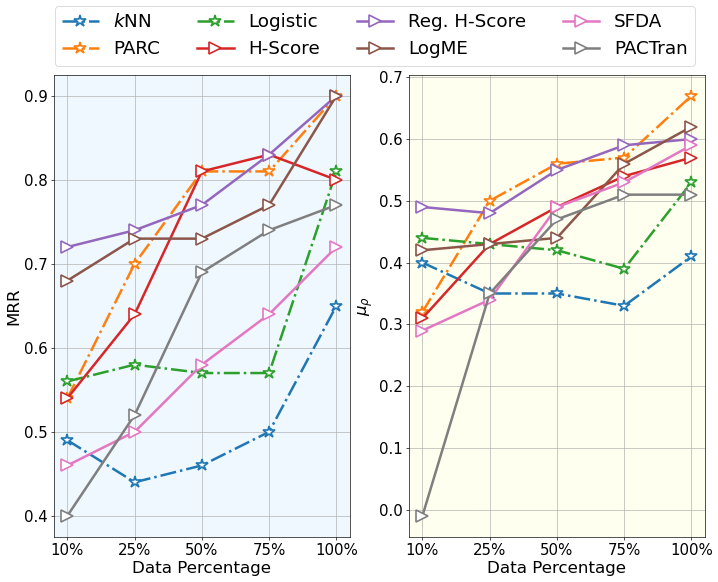

In [15]:
plot_methods = ["kNN-5-corr", "PARC-corr", "Logistic", "HScore", "HScoreR", "LogME", "SFDA", "PACTran-1-10"]

show_methods = [METHOD_SHOW_NAME[m] for m in plot_methods]
data_ratios = [0.1, 0.25, 0.5, 0.75, 1.0]

dims = list(main_results_plot[1].keys())
X = list(main_results_plot.keys())
Y_mrr = {}
Y_scc = {}

metric = 'MRR'
for m in plot_methods:
    Y_mrr[m] = []
    for r in data_ratios:
        Y_mrr[m] += [float(main_results_plot[r][int(best_dim_dict[m])]['overall'].query(f'Methods=="{m}"')[metric].item())]

metric = 'Mean SCC'
for m in plot_methods:
    Y_scc[m] = []
    for r in data_ratios:
        Y_scc[m] += [float(main_results_plot[r][int(best_dim_dict[m])]['overall'].query(f'Methods=="{m}"')[metric].item())]


line_styles = ['-.'] * 3 + ['-'] * 5
marker_styles = ['*'] * 3 + ['>'] * 5 

fig = plt.figure(figsize = (14,10), dpi=60)
axes = fig.subplots(nrows=1, ncols=2)

ax = fig.axes[0]
ax.set_facecolor("aliceblue")
for i, m in enumerate(plot_methods):
    ax.plot(["%d"%(float(x)*100)+"%" for x in X], Y_mrr[m], label=show_methods[i], mfc = "white", markeredgewidth=2, linestyle=line_styles[i], linewidth=3, marker=marker_styles[i], markersize=15)
ax.set_xlabel('Data Percentage', size=20)
ax.set_ylabel('MRR', size=20)

tick_size = 18

plt.sca(axes[0])
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.grid()
    
ax = fig.axes[1]
ax.set_facecolor("ivory")
for i, m in enumerate(plot_methods):
    ax.plot(["%d"%(float(x)*100)+"%" for x in X], Y_scc[m], label=show_methods[i], mfc = "white", markeredgewidth=2, linestyle=line_styles[i], linewidth=3, marker=marker_styles[i], markersize=15)
ax.set_xlabel('Data Percentage', size=20)
ax.set_ylabel(r'$\mu_{\rho}$', size=20)

plt.sca(axes[1])
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.grid()

lines, labels = fig.axes[-1].get_legend_handles_labels()
fig.legend(lines, labels, loc = 'upper left', fontsize=22, ncol=4, bbox_to_anchor=(0.115, 1.01))
plt.savefig('C:\\Users\\Jun Bai\\Desktop\\EMNLP2023\\data_size_variation.pdf', dpi = 100, bbox_inches = 'tight')
plt.show()

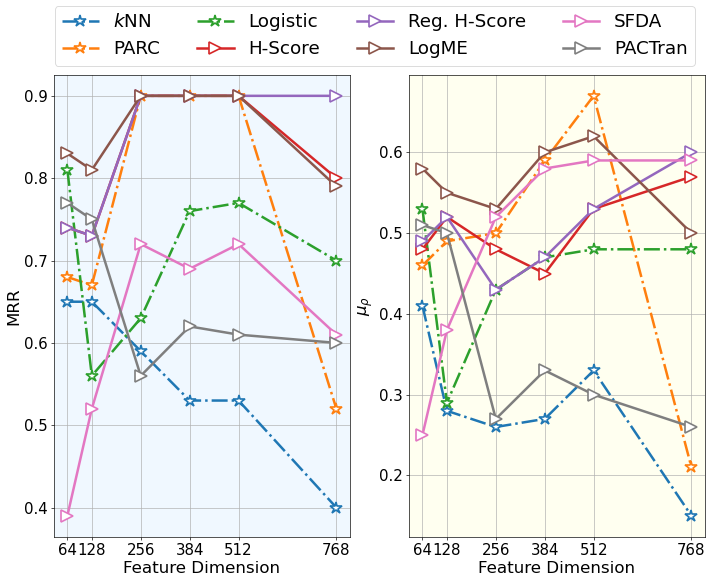

In [16]:
plot_methods = ["kNN-5-corr", "PARC-corr", "Logistic", "HScore", "HScoreR", "LogME", "SFDA", "PACTran-1-10"]

show_methods = [METHOD_SHOW_NAME[m] for m in plot_methods]
embedding_sizes = [64, 128, 256, 384, 512, 768]

dims = list(main_results_plot[1].keys())
X = embedding_sizes
Y_mrr = {}
Y_scc = {}

metric = 'MRR'
for m in plot_methods:
    Y_mrr[m] = []
    for e in embedding_sizes:
        Y_mrr[m] += [float(main_results_plot[1][e]['overall'].query(f'Methods=="{m}"')[metric].item())]

metric = 'Mean SCC'
for m in plot_methods:
    Y_scc[m] = []
    for e in embedding_sizes:
        Y_scc[m] += [float(main_results_plot[1][e]['overall'].query(f'Methods=="{m}"')[metric].item())]


line_styles = ['-.'] * 3 + ['-'] * 5
marker_styles = ['*'] * 3 + ['>'] * 5 

fig = plt.figure(figsize = (14,10), dpi=60)
axes = fig.subplots(nrows=1, ncols=2)

ax = fig.axes[0]
ax.set_facecolor("aliceblue")
for i, m in enumerate(plot_methods):
    ax.plot(X, Y_mrr[m], label=show_methods[i], mfc = "white", markeredgewidth=2, linestyle=line_styles[i], linewidth=3, marker=marker_styles[i], markersize=15)
ax.set_xlabel('Feature Dimension', size=20)
ax.set_ylabel('MRR', size=20)

tick_size = 18

plt.sca(axes[0])
plt.xticks(X, fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.grid()
    
ax = fig.axes[1]
ax.set_facecolor("ivory")
for i, m in enumerate(plot_methods):
    ax.plot(X, Y_scc[m], label=show_methods[i], mfc = "white", markeredgewidth=2, linestyle=line_styles[i], linewidth=3, marker=marker_styles[i], markersize=15)
ax.set_xlabel('Feature Dimension', size=20)
ax.set_ylabel(r'$\mu_{\rho}$', size=20)

plt.sca(axes[1])
plt.xticks(X, fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.grid()

lines, labels = fig.axes[-1].get_legend_handles_labels()
fig.legend(lines, labels, loc = 'upper left', fontsize=22, ncol=4, bbox_to_anchor=(0.115, 1.01))
plt.savefig('C:\\Users\\Jun Bai\\Desktop\\EMNLP2023\\feature_dimension_variation.pdf', dpi = 100, bbox_inches = 'tight')
plt.show()

In [27]:
df = best_results
for i in range(df.shape[0]):
    print(' & '.join(list(df.iloc[i])[:5])+ r' \\')

DSE-corr & 0.76 & 0.43 & 2.4h & 0.3s \\
DSE-dot & 0.38 & 0.20 & 2.4h & 0.1s \\
DSE-cos & 0.64 & 0.40 & 2.4h & 0.2s \\
DSE-l2 & 0.94 & 0.45 & 2.4h & 10.1s \\
PA & 0.50 & 0.29 & 2.4h & 4.5s \\
RSA-corr & 0.40 & 0.11 & 2.4h & 134.7s \\
RSA-cos & 0.47 & 0.14 & 2.4h & 131.7s \\
RSA-l2 & 0.30 & 0.06 & 2.4h & 128.2s \\
RSA-dot & 0.47 & 0.14 & 2.4h & 130.6s \\
DDS-corr & 0.24 & -0.06 & 2.4h & 22.1s \\
DDS-cos & 0.33 & -0.06 & 2.4h & 23.3s \\
DDS-dot & 0.33 & -0.03 & 2.4h & 17.8s \\
DDS-l2 & 0.23 & 0.03 & 2.4h & 19.9s \\
kNN-1-l2 & 0.47 & 0.24 & - & 1.6s \\
kNN-3-l2 & 0.45 & 0.34 & - & 1.4s \\
kNN-5-l2 & 0.47 & 0.27 & - & 1.5s \\
kNN-1-cos & 0.40 & 0.15 & - & 4.3s \\
kNN-3-cos & 0.48 & 0.34 & - & 6.9s \\
kNN-5-cos & 0.53 & 0.37 & - & 11.2s \\
kNN-1-corr & 0.44 & 0.19 & - & 33.7s \\
kNN-3-corr & 0.57 & 0.39 & - & 8.7s \\
kNN-5-corr & 0.65 & 0.41 & - & 21.0s \\
GBC & 0.44 & 0.22 & - & 0.6s \\
HScore & 0.80 & 0.57 & - & 37.5s \\
HScoreR & 0.90 & 0.60 & - & 33.4s \\
MSC-l2 & 0.61 & 0.08 & - & 4.6s 

In [39]:
main_results

,Methods,MRR,Spearman,Running Time
0,kNN (k=1),0.273,0.067,6.53s
1,kNN (k=3),0.352,0.254,6.57s
2,kNN (k=5),0.450,0.188,6.55s
3,GBC,0.504,0.196,0.29s
4,H-score,0.796,0.596,2.16s
5,Reg. H-score,0.796,0.596,2.11s
6,LFC,0.192,-0.197,9.07s
7,MSC,0.625,0.063,6.33s
8,PARC,0.556,0.281,89.42s
9,TransRate,0.192,-0.183,1.35s


In [40]:
for i in range(main_results.shape[0]):
    print(' & '.join(list(main_results.iloc[i][:1]) + ['%.3f'%s for s in main_results.iloc[i][1:-1]] + list(main_results.iloc[i][-1:]))+ r' \\')

kNN (k=1) & 0.273 & 0.067 & 6.53s \\
kNN (k=3) & 0.352 & 0.254 & 6.57s \\
kNN (k=5) & 0.450 & 0.188 & 6.55s \\
GBC & 0.504 & 0.196 & 0.29s \\
H-score & 0.796 & 0.596 & 2.16s \\
Reg. H-score & 0.796 & 0.596 & 2.11s \\
LFC & 0.192 & -0.197 & 9.07s \\
MSC & 0.625 & 0.063 & 6.33s \\
PARC & 0.556 & 0.281 & 89.42s \\
TransRate & 0.192 & -0.183 & 1.35s \\
DSE (MeanEmb) & 0.333 & 0.147 & 2.37h+0.19s \\
DSE (MeanSim) & 0.354 & 0.161 & 2.37h+0.41s \\
PA & 0.217 & -0.161 & 2.37h+2.48s \\
RSA & 0.325 & -0.071 & 2.37h+135.69s \\
DDS & 0.325 & -0.057 & 2.37h+24.48s \\
$\mathcal{N}$LEEP & 0.562 & 0.262 & 79.64s \\
SFDA & 0.521 & 0.558 & 10.95s \\
Logistic & 0.781 & 0.423 & 3.13s \\
LogME & 0.792 & 0.474 & 1.86s \\
EarlyStop (50 Steps) & 0.248 & 0.077 & 172.24s \\
EarlyStop (100 Steps) & 0.838 & 0.624 & 144.47s \\
EarlyStop (500 Steps) & 0.854 & 0.758 & 314.51s \\


In [35]:
f = np.random.standard_normal([5, 10])
np.cov(f, rowvar=False).shape

(10, 10)

In [71]:
for i in range(time_results.shape[0]):
    # print(' & '.join(list(time_results.iloc[i])[:1]+list(map(all2str, list(time_results.iloc[i])[1:]))) + r' \\')
    print(' & '.join([time_results.iloc[i][0], time_results.iloc[i][-1].replace(r'+',r'h+')+'s', r' \\']))

EarlyStop (100 Steps) & 144.47s &  \\
EarlyStop (500 Steps) & 314.51s &  \\
kNN (k=1) & 6.53s &  \\
kNN (k=3) & 6.57s &  \\
kNN (k=5) & 6.55s &  \\
Logistic & 3.13s &  \\
$\mathcal{N}$LEEP & 79.64s &  \\
GBC & 0.29s &  \\
H-score & 2.16s &  \\
Reg. H-score & 2.11s &  \\
LogME & 1.86s &  \\
LFC & 9.07s &  \\
MSC & 6.33s &  \\
PARC & 89.42s &  \\
SFDA & 10.95s &  \\
TransRate & 1.35s &  \\
DSE (MeanEmb) & 2.37h+0.19s &  \\
DSE (MeanSim) & 2.37h+0.41s &  \\
PA & 2.37h+2.48s &  \\
RSA & 2.37h+135.69s &  \\
DDS & 2.37h+24.48s &  \\


In [13]:
all2str = lambda x:"%.3f"%x
for i in range(corr_results.shape[0]):
    print(' & '.join(list(corr_results.iloc[i])[:1]+list(map(all2str, list(corr_results.iloc[i])[1:]))) + r' \\')

EarlyStop (100 Steps) & 0.092 & 0.934 & 0.935 & 0.906 & 0.680 & 0.987 & 0.900 & 0.622 & 0.757 \\
EarlyStop (500 Steps) & 0.892 & 0.916 & 0.930 & 0.956 & 0.936 & 0.855 & 0.908 & 0.635 & 0.878 \\
kNN (k=1) & 0.650 & 0.381 & -0.644 & -0.091 & 0.674 & 0.468 & -0.270 & -0.540 & 0.079 \\
kNN (k=3) & 0.729 & -0.006 & -0.150 & -0.088 & 0.683 & 0.801 & -0.393 & -0.010 & 0.196 \\
kNN (k=5) & 0.571 & 0.071 & -0.504 & -0.118 & 0.716 & 0.682 & 0.142 & 0.076 & 0.204 \\
Logistic & 0.793 & 0.078 & 0.069 & 0.550 & 0.891 & 0.535 & 0.748 & 0.390 & 0.507 \\
$\mathcal{N}$LEEP & 0.491 & -0.843 & -0.286 & 0.666 & 0.613 & 0.726 & 0.711 & 0.680 & 0.345 \\
GBC & 0.674 & -0.928 & -0.067 & 0.367 & 0.492 & 0.690 & 0.826 & -0.277 & 0.222 \\
H-score & 0.950 & -0.055 & 0.663 & 0.892 & 0.934 & 0.769 & 0.977 & 0.231 & 0.670 \\
Reg. H-score & 0.950 & -0.055 & 0.663 & 0.892 & 0.934 & 0.769 & 0.977 & 0.231 & 0.670 \\
LogME & 0.929 & -0.576 & 0.661 & 0.738 & 0.897 & 0.723 & 0.936 & -0.471 & 0.480 \\
LFC & -0.474 & -0.484 &